# Importing Libraries

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm

# Connection to drive

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab. ")
except:
    IN_COLAB = False
    print("Not running on Google Colab. ")

Not running on Google Colab. 


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if IN_COLAB:
    os.chdir('/content/gdrive/MyDrive/Tesi/dataset')
else:
    os.chdir('./dataset')

# Downloading, Reading and Merging Data

In [5]:
def move_directories(orig_path, dest_path):
    # Check if the destination folder exists, otherwise create it
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    
    # Iter over all files and folders in the source directory
    for item in os.listdir(orig_path):
        orig_item_path = os.path.join(orig_path, item)
        
        # Check if it is a folder
        if os.path.isdir(orig_item_path):
            # Defines the destination path for the folder
            dest_item_path = os.path.join(dest_path, item)
            
            # Move the folder by renaming it
            os.rename(orig_item_path, dest_item_path)
            print(f"Moved directory: {orig_item_path} -> {dest_item_path}")

In [6]:
import kagglehub

# Check if some subdirectories are not empty
path_to_check = "./LUFlow/"
subdirs = [d for d in os.listdir(path_to_check) if os.path.isdir(os.path.join(path_to_check, d))]
non_empty_subdirs = [d for d in subdirs if os.listdir(os.path.join(path_to_check, d))]

dest_path = './LUFlow'

if non_empty_subdirs:
    print("Non-empty subdirectories:", non_empty_subdirs)
    print("Skip downloading.")
else:
    print("All subdirectories are empty.")
    print("Download dataset.")

    # Download latest version
    path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")

    print("Path to dataset files:", path)

    move_directories(path, dest_path)

Non-empty subdirectories: ['GranuleData', '2021', '2020', '2022']
Skip downloading.


/home/ubdeskiovaro/anaconda3/envs/thesis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
df_list = []
i = 0

selected_columns = ['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto', 'time_start', 'label']
dtype_dict = {'bytes_in': np.int32, 'bytes_out': np.int32, 'num_pkts_out': np.int32, 'num_pkts_in': np.int32, 'proto': np.int32, 'time_start': np.int64, 'label': str}

#subset = '2022'

for root, dirs, files in os.walk(dest_path):
    for file in files:
        # checks if 'file' does not exist in the directory
        # checks if 'csv' is in the file name
        # checks if a particular string is in the file name
        # insert in the list only a subset of the existing files
        if not os.path.isfile(file) and 'csv' in file: #and subset in file:
            chunk_iter = pd.read_csv(os.path.join(root, file), chunksize=10000, usecols=selected_columns, dtype=dtype_dict)
            for chunk in chunk_iter:
                df_list.append(chunk)
            
            del chunk_iter
            gc.collect()
            i += 1

df = pd.concat(df_list, ignore_index=True)

del df_list
gc.collect()

0

# Exploratory Data Analysis

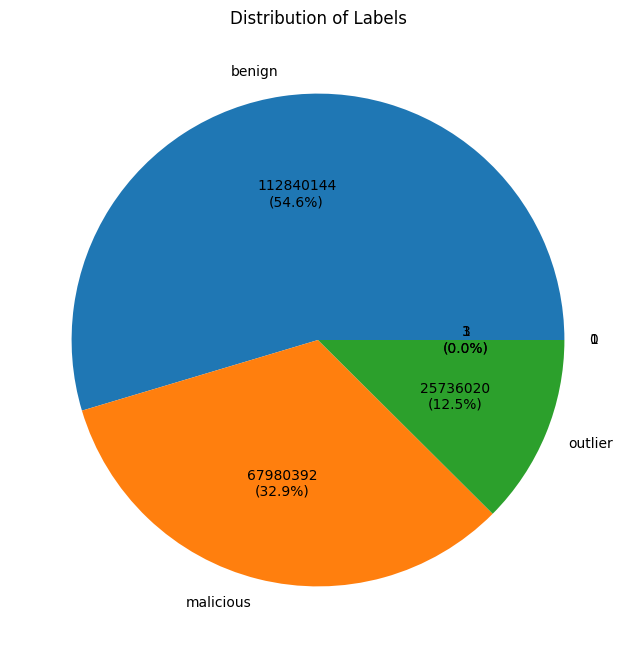

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Plot using Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

# Show the plot
plt.title('Distribution of Labels')
plt.show()

# Data Preprocessing

In [9]:
df.dropna(axis=1, inplace = True)

missing_values = df.isnull().sum()
print(missing_values)

bytes_in        0
bytes_out       0
num_pkts_out    0
num_pkts_in     0
proto           0
time_start      0
label           0
dtype: int64


In [10]:
outliers = df['label'] == 'outlier'
df = df[~outliers]

df = df.reset_index(drop=True)

del outliers
gc.collect()

2539

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the label column
df['label'] = label_encoder.fit_transform(df['label'])

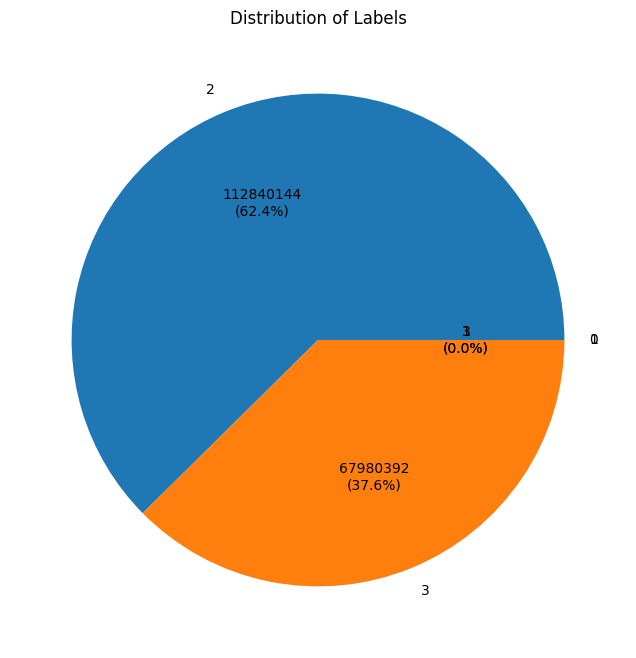

In [12]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

# Show the plot
plt.title('Distribution of Labels')
plt.show()

In [13]:
df.columns

Index(['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto',
       'time_start', 'label'],
      dtype='object')

### Preparation of index for the granules varying time window dimensions

In [14]:
perc = 0.8

rows_perc = int(len(df)*perc)

df_test = df.iloc[rows_perc:]
df_train = df.iloc[:rows_perc]

In [15]:
time_slices = [16, 128, 256, 1024, 2048, 3016]

matching_indices_slices = {}

time_start_values = df['time_start'].values
n = time_start_values

for ts in time_slices:
  # maximum time limit of the granule
  limit = time_start_values[0] + ts
  # number of granules
  num_gran = 0
  group_dict = {num_gran:[0]}

  for i in range(1, len(n)):
      # if the value of time_start is greater than limit then limit is updated and
      # it is initilized a new granule
      # otherwise the index of the row is added to matching_indeces_slices
      if time_start_values[i] >= limit:
        limit = time_start_values[i] + ts
        num_gran += 1

        group_dict[num_gran] = [i]
      else:
        group_dict[num_gran].append(i)

  matching_indices_slices[ts] = group_dict
  del group_dict
  gc.collect()

In [16]:
# Separate features (X) and target variable (y)
X_train = df.loc[:, df.columns != 'label']
y_train = df['label']

del df
gc.collect()

0

In [17]:
# Separate features (X) and target variable (y)
X_test = df_test.loc[:, df_test.columns != 'label']
y_test = df_test['label']


del df_test
gc.collect()

0

In [18]:
X_train

,bytes_in,bytes_out,num_pkts_out,num_pkts_in,proto,time_start
0,270,191,6,6,6,1611879521657929
1,270,191,6,6,6,1611879523212918
2,99123,57189,184,361,18,1611879524041252
3,53729,11946,122,257,18,1611879542819765
4,270,191,6,6,6,1611879521657929
...,...,...,...,...,...,...
180820526,1644,24070,24,8,6,1655251137012449
180820527,3984,21084,31,18,6,1655251158201494
180820528,5476,10959,77,30,6,1655251150935134
180820529,350,4775,5,2,6,165525117202365


In [19]:
y_train

0            1
1            1
2            0
3            1
4            3
            ..
180820526    2
180820527    2
180820528    2
180820529    2
180820530    2
Name: label, Length: 180820531, dtype: int64

# Model Training and Performance

In [20]:
import time

# X_train_granule = {}
# y_train_granule = {}

columns = ['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto', 'time_start', 'label']

if not os.path.exists('./LUFlow/GranuleData'):
    os.makedirs('./LUFlow/GranuleData')

for time_slice in time_slices:
    # X_train_granule[time_slice] = {}
    # y_train_granule[time_slice] = {}

    t = time.strftime("%Y%m%d-%H%M%S")
    print('Inizio for',t)

    df = pd.DataFrame(columns=columns)
    df.to_csv(f'./LUFlow/GranuleData/clustering_granules_{time_slice}.csv', index=False)

    for granule, granule_indeces in tqdm(matching_indices_slices[time_slice].items()):
        # Using .loc[] to slice and reduce calls to iloc/head/mode functions
        granule_data = X_train.loc[granule_indeces, ['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto', 'time_start']]
        granule_data_y = y_train.loc[granule_indeces]
        
        # Vectorized aggregation for sum and start time extraction
        # X_train_granule[time_slice][granule] = granule_data[['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto']].sum()
        row = granule_data[['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto']].sum()
        
        # X_train_granule[time_slice][granule]['time_start'] = granule_data['time_start'].iloc[0]
        row['time_start'] = granule_data['time_start'].iloc[0]
        
        # Vectorized mode calculation
        # y_train_granule[time_slice][granule] = granule_data.mode().iloc[0]
        row['label'] = granule_data_y.mode().iloc[0]

        row = pd.DataFrame([row])
        row.to_csv(f'./LUFlow/GranuleData/clustering_granules_{time_slice}.csv', mode='a', index=False, header=False)

    del granule_data, granule_data_y, row
    gc.collect()


Inizio for 20241105-115518


100%|██████████| 28134/28134 [19:00:57<00:00,  2.43s/it]   


Inizio for 20241106-065650


100%|██████████| 25924/25924 [16:50:01<00:00,  2.34s/it]   


Inizio for 20241106-234717


100%|██████████| 24425/24425 [16:06:45<00:00,  2.37s/it]   


Inizio for 20241107-155427


100%|██████████| 21518/21518 [14:12:49<00:00,  2.38s/it]   


Inizio for 20241108-060738


100%|██████████| 20293/20293 [13:16:22<00:00,  2.35s/it]   


Inizio for 20241108-192424


100%|██████████| 19707/19707 [12:38:36<00:00,  2.31s/it]   


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import math

list_reports = {}
best_models = {}
bcc_reports = {}
mcc_reports = {}

# Random Forest with GridSearchCV
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring='accuracy')


for time_slice in tqdm(time_slices):
  # y_train_list = list(y_train_granule[time_slice].values())
  # X_train_granule_df = pd.DataFrame.from_dict(X_train_granule[time_slice], orient='index')
  granulated_data = pd.read_csv(f'./LUFlow/GranuleData/clustering_granules_{time_slice}.csv')

  x_train = granulated_data.loc[:, granulated_data.columns != 'label']
  y_train_list = list(granulated_data['label'].values())

  list_reports[time_slice] = {}
  best_models[time_slice] = {}

  rf_grid.fit(x_train, y_train_list)
  rf_best_model = rf_grid.best_estimator_

  rf_pred = rf_best_model.predict(X_test)
  report = classification_report(y_test, rf_pred, output_dict=True)

  tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()

  bcc_reports[time_slice] = (tp/(tp+fn) + tn/(tn+fp))/2
  mcc_reports[time_slice] = (tp*tn - fp*fn)/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


  list_reports[time_slice] = pd.DataFrame(report).transpose()
  best_models[time_slice] = rf_best_model


  0%|          | 0/6 [00:00<?, ?it/s]


TypeError: 'numpy.ndarray' object is not callable

In [24]:
granulated_data

,bytes_in,bytes_out,num_pkts_out,num_pkts_in,proto,time_start,label
0,270,191,6,6,6,1611879521657929,1
1,270,191,6,6,6,1611879523212918,1
2,99123,57189,184,361,18,1611879524041252,0
3,207121,81463,440,887,66,1611879542819765,3
4,126105,162913,480,376,24,1611879615007283,2
...,...,...,...,...,...,...,...
28129,41696,70929,186,204,18,1655251151257915,2
28130,343,40586,6,7,6,1655251163336839,2
28131,93534,185795,473,650,71,1655251174341041,2
28132,14999,37433,41,67,18,1655251174344856,2


# Model Performance

The performance metrics used by the approach proposed in [8]:
-	Accuracy is the proportion of accurately classified datapoints in the test set in relation to the total number of instances.
-	Precision is the ratio of detected positive cases to all expected positive instances.
-	Recall is the ratio of samples classified as positive to all expected positive instances.
-	F1-score is a harmonic mean of recall and precision.
-	MCC (Matthews Correlation Coefficient) determines the correlation coefficient between the anticipated and actual classifications.
-	BCC (Balanced Accuracy) is used for situations with data imbalance.

In [ ]:
# Go up one directory
os.chdir('..')

# Check if 'reports' directory exists, otherwise create it
if not os.path.exists('reports'):
    os.mkdir('reports')

# Check if 'best_models' directory exists, otherwise create it
if not os.path.exists('best_models'):
    os.mkdir('best_models')

In [ ]:
import time
import joblib

subset = 'all'

#timestr = time.strftime("%Y%m%d-%H%M%S")
string = 'clustering_'+subset+'_'+time.strftime("%Y%m%d-%H%M%S")


os.mkdir(f'./reports/{string}')
os.mkdir(f'./best_models/{string}')

os.chdir(f'./reports/{string}')

for report in list_reports:
  list_reports[report].to_csv(f'report_{report}.csv')

for bcc in bcc_reports:
  with open(f'bcc_{bcc}.txt', 'w') as f:
    f.write(str(bcc_reports[bcc]))

for mcc in mcc_reports:
  with open(f'mcc_{mcc}.txt', 'w') as f:
    f.write(str(mcc_reports[mcc]))

os.chdir(f'../../best_models/{string}')

for model in best_models:
  joblib.dump(best_models[model], f'model_{model}_{string}.joblib')

In [ ]:
equidistant_x = np.arange(len(time_slices))
feature_to_print = 'precision'

plt.plot(equidistant_x, [list_reports[i].loc['accuracy'][feature_to_print] for i in time_slices])

plt.title(f'{feature_to_print} over time_slices')
plt.xticks(equidistant_x, time_slices)
plt.xlabel('time slices')
plt.ylabel(f'{feature_to_print}')
# plt.legend()
plt.show()

In [ ]:
for time_slice in time_slices:
  print(f'Report {time_slice}: \n{list_reports[time_slice]}\n')
  print(f'BCC {time_slice}: {bcc_reports[time_slice]}\n')
  print(f'MCC {time_slice}: {mcc_reports[time_slice]}')
  print('\n')